In [14]:
import pandas as pd
import re
import pymorphy2
from sklearn.preprocessing import normalize
import numpy as np
from collections import Counter
from joblib import Parallel, delayed
import multiprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import math
import scipy.spatial
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import pickle

### Считываем данные

In [2]:
data = pd.read_csv('primary_debates_cleaned.csv')


### Чистим данные

In [3]:
def clean_df(df, x=1, y=15): 
    #Чистим изначальный массив, берем определенное количество спикеров, по частоте их выступлений
    
    ind = df.Speaker.value_counts()[x:y].index # берем имена спикеров
        
    new_df=df[df.Speaker==ind[0]] # первый элемент дата фрейма 
    for i in range(1,len(ind)): # проходим по остальным элементам
        new_df=pd.concat([new_df,df[df.Speaker==ind[i]]]) # добавляем последующие подмассивы в основной

    return new_df # выводим

In [4]:
df = clean_df(data)
train = df.Text.values # считываем только текст

### Векторизуем и обрабатываем Tfidf

In [15]:
count_vect = CountVectorizer()
bag_of_words=count_vect.fit(train) #векторизуем мешком слов
X_train_counts = count_vect.fit_transform(train)

tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit(X_train_counts) #далее тф идф методика
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
vecs = X_train_tfidf

### Сохраняем модели

In [21]:
pickle.dump(tfidf,open('tfidf_model.pkl','wb'))
pickle.dump(bag_of_words,open('bag_of_word.pkl','wb'))

In [22]:
new_model = pickle.load(open('bag_of_word.pkl','rb'))

### Центальный вектор для каждого класса

In [6]:
def vec_operations(vecs): #  берем некую матрицу
    amount = float(vecs.shape[0]) # находим в ней количество строк
    center_vec = vecs.sum(axis = 0)/amount # усреднеяем значения вектора 
    return center_vec/math.sqrt(sum(center_vec**2)) # нормализуем центральный вектор

In [7]:
def get_indexing_of_events(speaker): #проиндексируем события соотвесвенно спикеру
    speaker_events = data[data.Speaker == speaker] # по конкретному спикеру
    return speaker_events.Line.values-1 #индексация должна быть с нуля

In [8]:
def describe_each_class(df): #считаем центральный вектор
    classes = df.Speaker.unique() # какие классы есть
    centers = np.zeros((len(classes),vecs.shape[1])) ### матрица центров = колво классов * длинна вектора
    
    for index,cl in enumerate(classes):
        indexes = get_indexing_of_events(cl) # получаем индексы класса
        vectors_for_cl = vecs[indexes].toarray() # векторы относящиеся к этому классу
        center_vec_normalized = vec_operations(vectors_for_cl) # центральный вектор для этого класса
        
        centers[index] = center_vec_normalized # записываем этот центр в матрицу центров
    return centers

### Считаем косинусную дистанцию

In [9]:
clas = describe_each_class(df) # количество классов
vecs = vecs.toarray() # векторы в массив
dist = np.zeros((len(vecs[:,1]),len(clas[:,0]))) # массив куда будем сохранять значения косинуса

In [10]:
for j in range(len(vecs[:,1])): # сравниваем каждый текст
    for i in range(len(clas[:,0])):# с каждым классом
        dist[j,i] = scipy.spatial.distance.cosine(vecs[j,:],clas[i])  # считаем косинусную меру сравниваня с каждым классом постепенно

### Оцениваем эффективность по разнице между максимальным косинусом и минимальным

In [ ]:
mx = np.zeros(len(dist[:,0])) # создаем вектор для максимальных
mn = np.zeros(len(dist[:,0])) # создаем вектор для минимальных значений

for i in range(6324):
    mx[i] = max(dist[i,:])# Максимальное значение дистанции для каждого текста 
    mn[i] = min(dist[i,:])# Минимальное значение дистанции для каждого текста


In [46]:
dist[4200:4300,:]

array([[ 0.90994525,  0.91576337,  0.91982617, ...,  0.92560387,
         0.93190039,  0.92770517],
       [ 0.91873665,  0.9291449 ,  0.92566203, ...,  0.94111549,
         0.94595411,  0.93977306],
       [ 0.85854777,  0.84636829,  0.83988988, ...,  0.85451205,
         0.83927635,  0.85950389],
       ..., 
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

### Оценим разницу между минимумом и максимумом

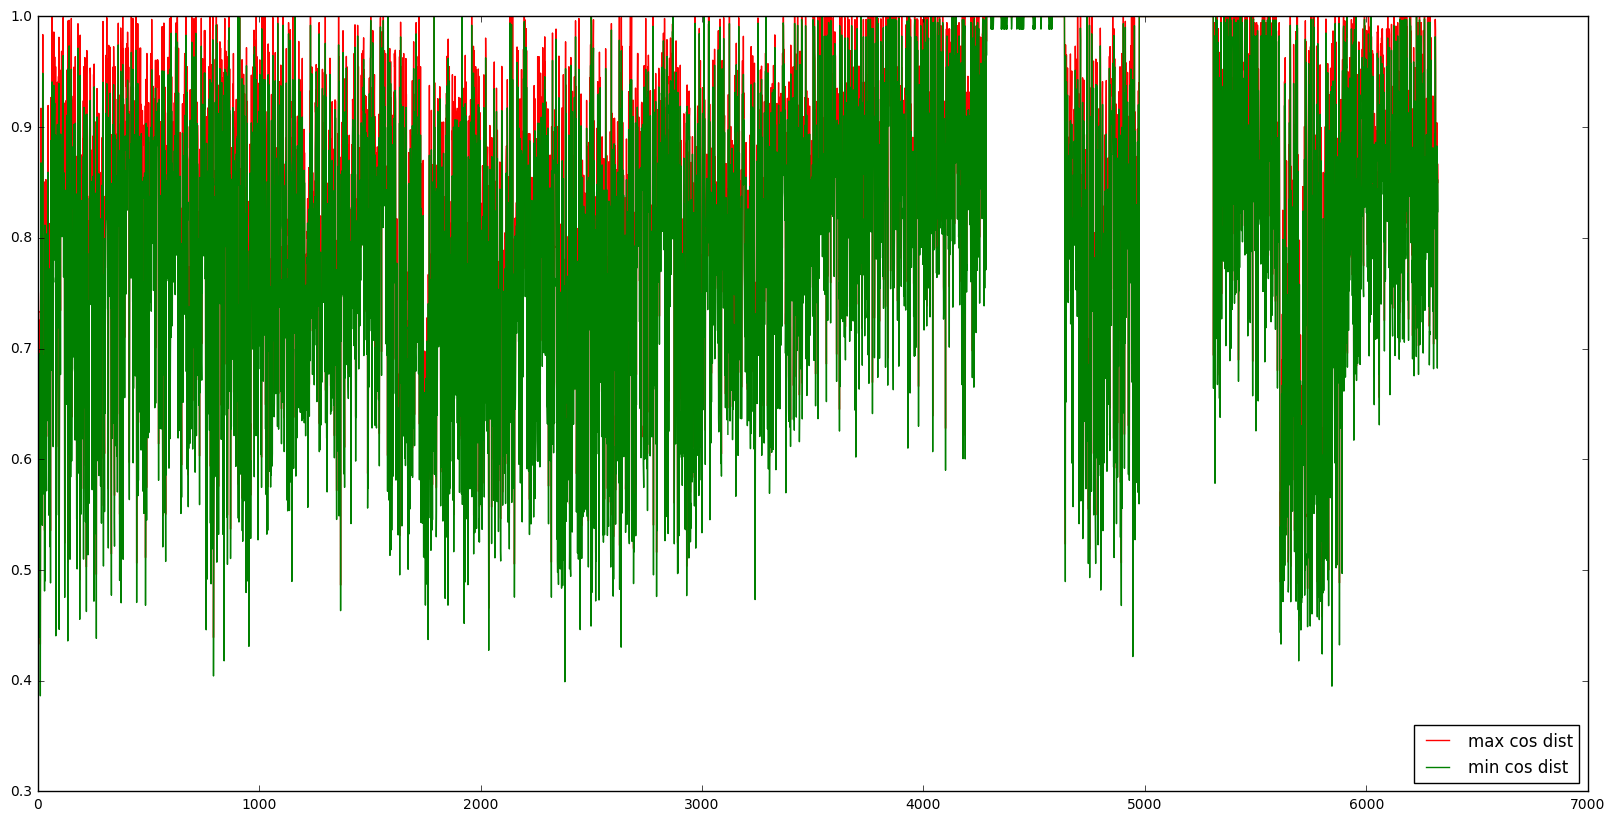

In [43]:
plt.figure(figsize=(20,10))
plt.plot(range(6324),mx,c="r",label='max cos dist')
plt.plot(range(6324),mn,c="g",label='min cos dist')
plt.legend(loc='lower right')

### В идеале должно быть

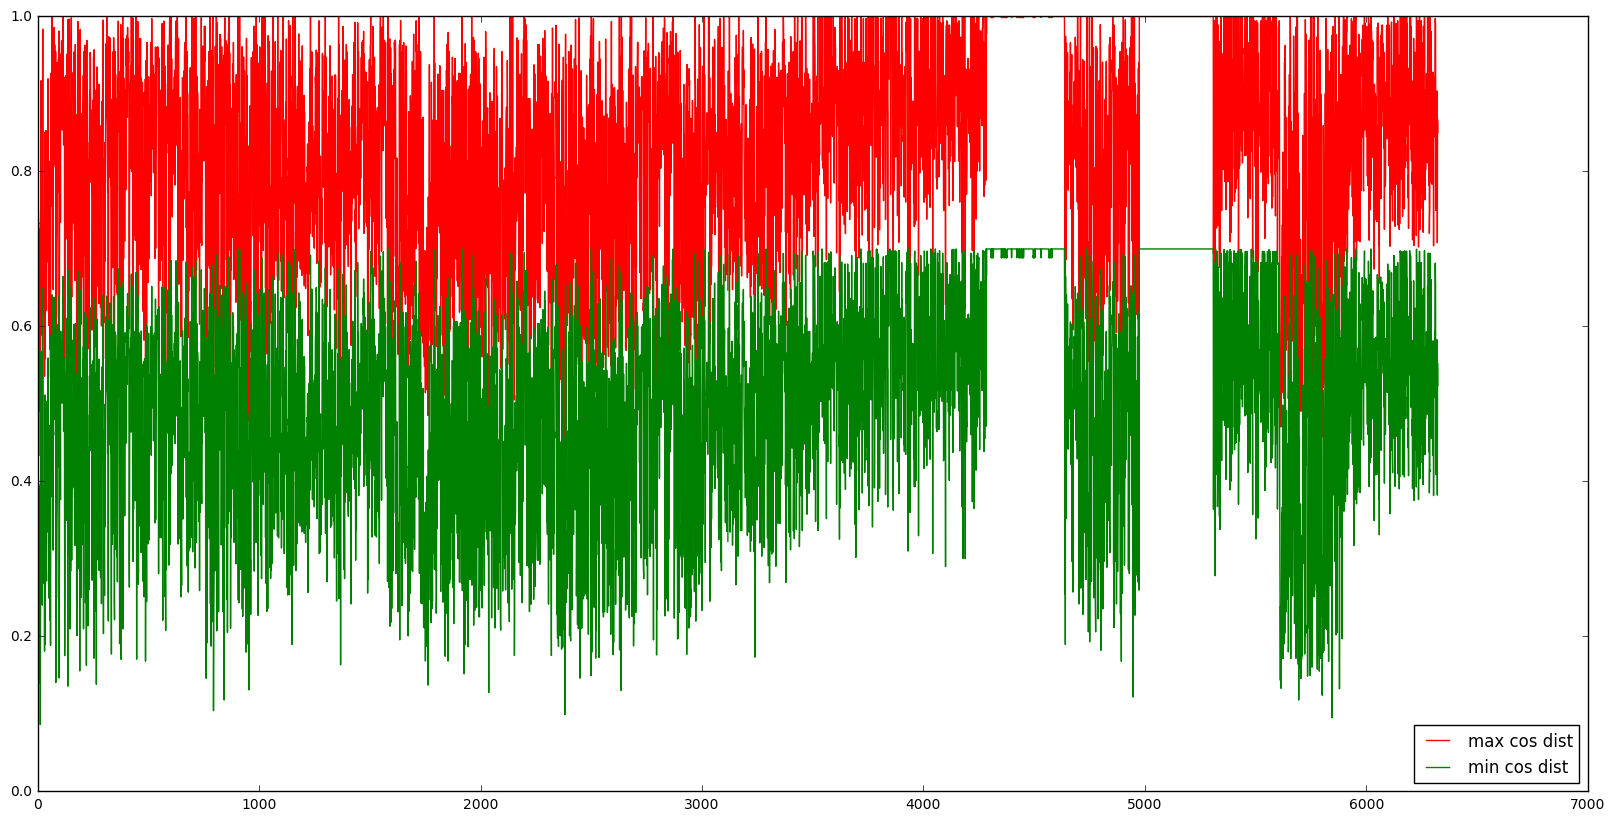

In [48]:
plt.figure(figsize=(20,10))
plt.plot(range(6324),mx,c="r",label='max cos dist')
plt.plot(range(6324),mn-0.3,c="g",label='min cos dist')
plt.legend(loc='lower right')

### Косинусная мера не подходит